## 11.2 粒子フィルタによる状態の推定

### 11.2.1 例: 人工的なローカルレベルモデル

まずは，あえてパラメータが全て既知である線形・ガウス型状態空間モデルを対象に，その結果をカルマンフィルタと比較する．  
モデルとデータには「9.2 ローカルレベルモデル」のコード9.1で準備した，人工的なローカルレベルモデルと生成データを用いる．  
粒子フィルタの実行における粒子数は10,000とし，状態抽出用の提案分布には状態方程式を適用する（(11.2)式を用いる）．

#### フィルタリング

In [1]:
#【パラメータが既知のローカルレベルモデルで粒子フィルタリング（自作）】

# 前処理
set.seed(4521)

# 粒子フィルタの事前設定
N <- 10000                    # 粒子数

# 人工的なローカルレベルモデルに関するデータを読み込み
load(file = "ArtifitialLocalLevelModel.RData")

# ※注意：事前分布を時点1とし、本来の時点1~t_maxを+1シフトして2~t_max+1として扱う

# データの整形（事前分布に相当するダミー分（先頭）を追加）
y <- c(NA_real_, y)

# リサンプリング用のインデックス列は全時点で保存しておく
k <- matrix(1:N, nrow = N, ncol = t_max+1)

# 事前分布の設定

# 粒子（実現値）
x <- matrix(NA_real_, nrow = t_max+1, ncol = N)
x[1, ] <- rnorm(N, mean = mod$m0, sd = sqrt(mod$C0))

# 粒子（重み）
w <- matrix(NA_real_, nrow = t_max+1, ncol = N)
w[1, ] <- 1 / N

# 時間順方向の処理
for (t in (1:t_max)+1){
  # 状態方程式：粒子（実現値）を生成
  x[t, ] <- rnorm(N, mean = x[t-1, ], sd = sqrt(mod$W))

  # 観測方程式：粒子（重み）を更新
  w[t, ] <- w[t-1, ] * dnorm(y[t], mean = x[t, ], sd = sqrt(mod$V))

  # 重みの規格化
  w[t, ] <- w[t, ] / sum(w[t, ])

  # リサンプリング
  
  # リサンプリング用のインデックス列
  k[, t] <- sample(1:N, prob = w[t, ], replace = TRUE, size = N)

  # 粒子（実現値）：リサンプリング用のインデックス列を新たな通番とする
  x[t, ] <- x[t, k[, t]]

  # 粒子（重み）：リセット
  w[t, ] <- 1 / N
}

# 結果の整形：事前分布の分（先頭）を除去等
y <- ts(y[-1])
k <- k[, -1, drop = FALSE]
x <- x[-1, , drop = FALSE]
w <- w[-1, , drop = FALSE]

# 平均・25%値・75%値を求める
scratch_m       <- sapply(1:t_max, function(t){
                     mean(x[t, ])
                   })
scratch_m_quant <- lapply(c(0.25, 0.75), function(quant){
                     sapply(1:t_max, function(t){
                       quantile(x[t, ], probs = quant)
                     })
                   })

フィルタリングの処理では事前分布を時点1とし，本来の時点1, ..., `t_max` を+1シフトして2, ..., `t_max`+1 として扱う．  
観測値なども時点を扱いやすくする目的で，先頭分にダミーを1つ追加している．

次に，リサンプリング用のインデックス列，粒子の実現値，粒子の重みに関して，必要となる領域を事前に確保する．  
大きさが既知の変数はあらかじめ領域を確保しておいた方が，（Rでは特に）実行速度の面で有利となる．  
なお，リサンプリング用のインデックス列を全時点で保存するのは，後の平滑化で北川アルゴリズムを実行する際に必要になるため．  
実現値と重みについては，事前分布に基づき時点1に対して初期化を行う．

ループの中では，アルゴリズム11.1に沿って処理が記載されている．
- 確率分布表現の状態方程式 (5.10) 式に基づき，状態方程式から実現値を抽出する．
- 確率分布表現の観測方程式 (5.11) 式に基づき，重みを更新する．
- 重みの規格化とリサンプリングを行う．

リサンプリング用のインデックス列を求めるために，Rの関数 `sample()` を利用している（多項分布に基づく復元抽出法，多項リサンプリング）．

これら一連の処理における粒子別の対応は，Rのベクトル化機能を用いている．
ループを使って粒子ごとに処理を実装することもできるが，Rでは特に遅くなるためベクトル化機能を活用した．

##### 図11.3: 自作粒子フィルタリングとカルマンフィルタリング（パラメータが既知の線形・ガウス型状態空間モデル）

##### (a) 平均

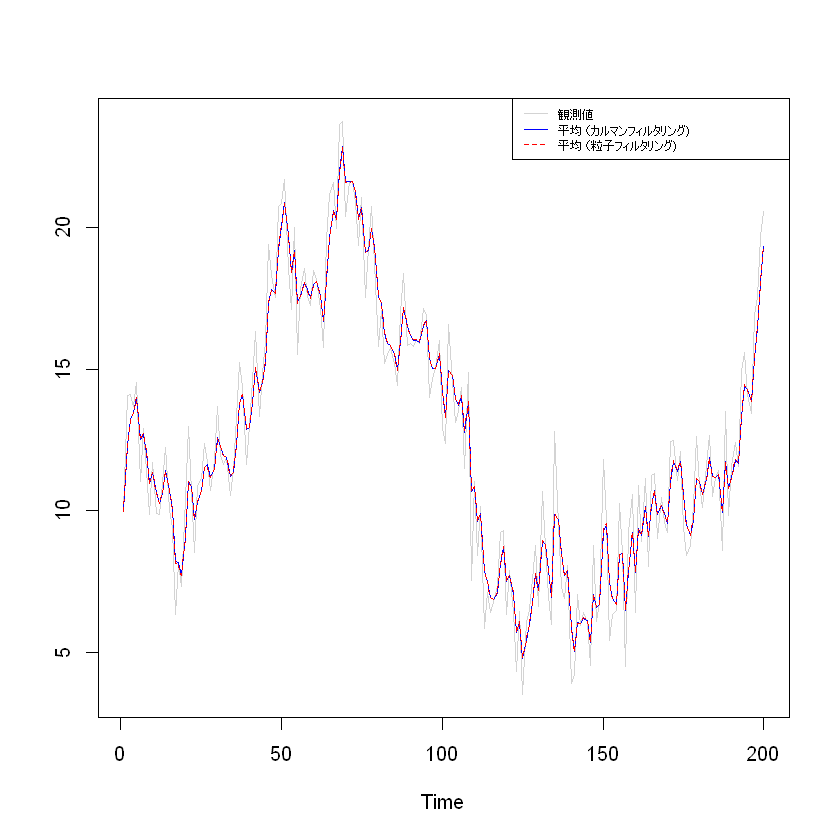

In [2]:
# 結果のプロット
ts.plot(cbind(y, m, scratch_m),
        col = c("lightgray", "blue", "red"),
        lty = c("solid", "solid", "dashed"))

# 凡例
legend(legend = c("観測値", "平均 （カルマンフィルタリング)",  "平均 （粒子フィルタリング)"),
       lty = c("solid", "solid", "dashed"),
       col = c("lightgray", "blue", "red"),
       x = "topright", text.width = 70, cex = 0.6)

##### (b) 50%区間

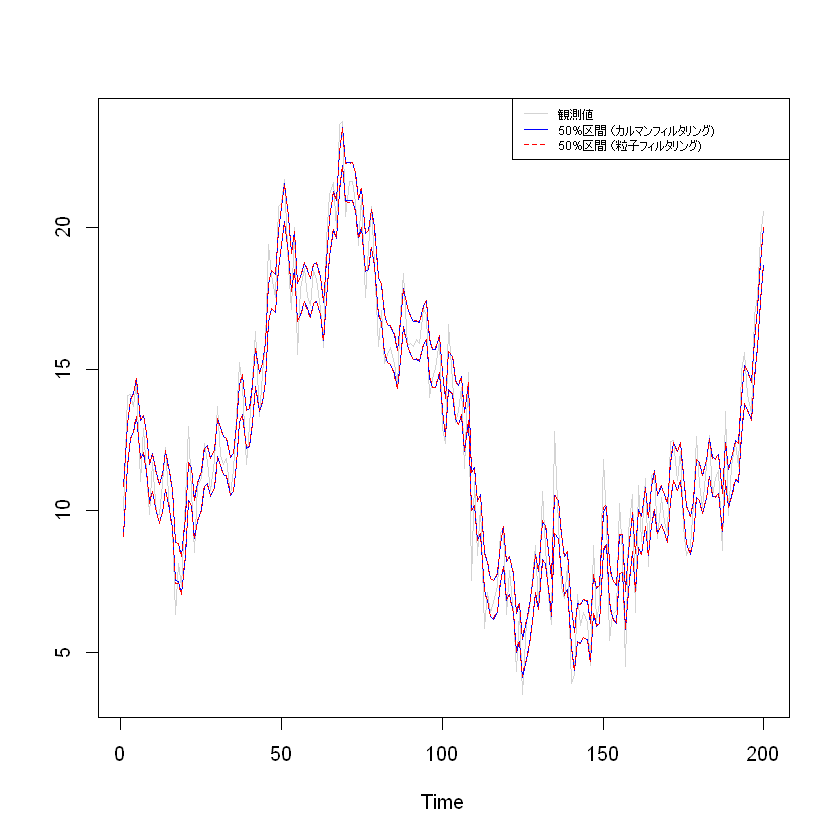

In [3]:
# 結果のプロット
ts.plot(cbind(y, do.call("cbind", m_quant), do.call("cbind", scratch_m_quant)),
        col = c("lightgray", "blue", "blue", "red", "red"),
        lty = c("solid", "solid", "solid", "dashed", "dashed"))


# 凡例
legend(legend = c("観測値", "50%区間 （カルマンフィルタリング)",  "50%区間 （粒子フィルタリング)"),
       lty = c("solid", "solid", "dashed"),
       col = c("lightgray", "blue", "red"),
       x = "topright", text.width = 70, cex = 0.6)

図11.3を確認すると，両者の結果はほぼ一致する（グラフがほぼ重なっている)．

#### 予測

In [4]:
#【パラメータが既知のローカルレベルモデルで粒子予測（自作）】

# 前処理
set.seed(4521)

# 未来時点のデータ領域を追加
x <- rbind(x, matrix(NA_real_, nrow = 10, ncol = N))
w <- rbind(w, matrix(NA_real_, nrow = 10, ncol = N))

# 時間順方向の処理
for (t in t_max+(1:10)){
  # 状態方程式：粒子（実現値）を生成
  x[t, ] <- rnorm(N, mean = x[t-1, ], sd = sqrt(mod$W))

  # 粒子（重み）を更新
  w[t, ] <- w[t-1, ]
}

# 平均・25%値・75%値を求める
scratch_a       <- sapply(t_max+(1:10), function(t){
                     mean(x[t, ])
                   })
scratch_a_quant <- lapply(c(0.25, 0.75), function(quant){
                     sapply(t_max+(1:10), function(t){
                       quantile(x[t, ], probs = quant)
                     })
                   })

ループの中では，アルゴリズム11.2に沿って処理が記載されている．
- 確率分布表現の状態方程式 (5.10) 式に基づき，状態方程式から実現値を抽出する．
- 重みには同じ値が適用され続ける．

#### 図11.4: 自作粒子予測とカルマン予測（パラメータが既知の線形・ガウス型状態空間モデル）

In [5]:
# ts型に変換
scratch_a <- ts(scratch_a, start = t_max+1)
scratch_a_quant <- lapply(scratch_a_quant, function(dat){
                     ts(dat, start = t_max+1)
                   })

##### (a) 平均

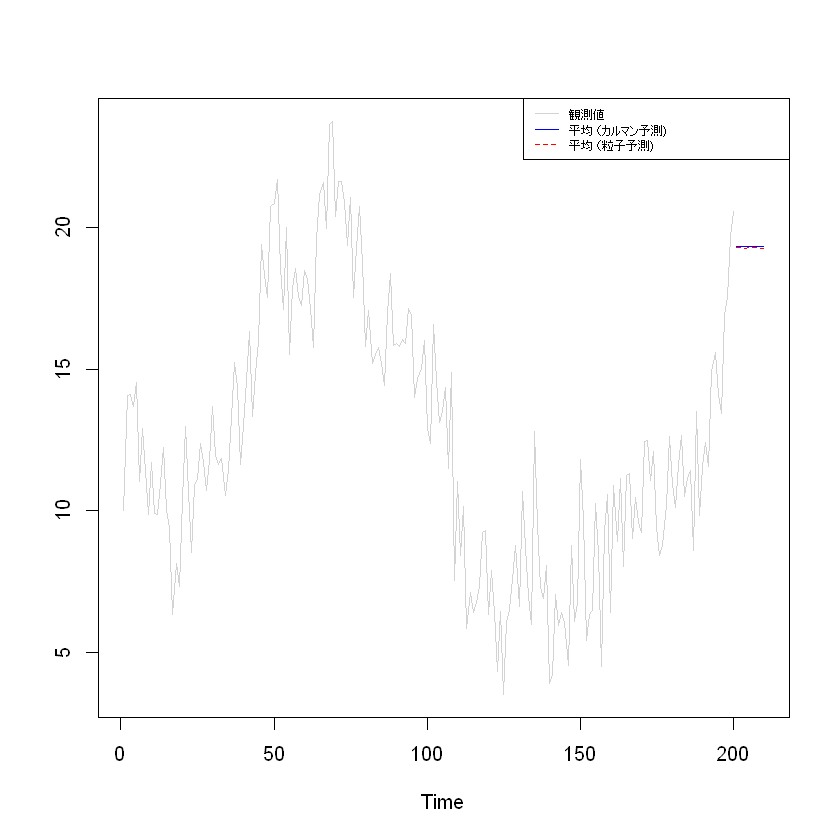

In [6]:
# 結果のプロット
ts.plot(cbind(y, a, scratch_a),
        col = c("lightgray", "blue", "red"),
        lty = c("solid", "solid", "dashed"))

# 凡例
legend(legend = c("観測値", "平均 （カルマン予測)",  "平均 （粒子予測)"),
       lty = c("solid", "solid", "dashed"),
       col = c("lightgray", "blue", "red"),
       x = "topright", text.width = 70, cex = 0.6)

##### (b) 50%区間

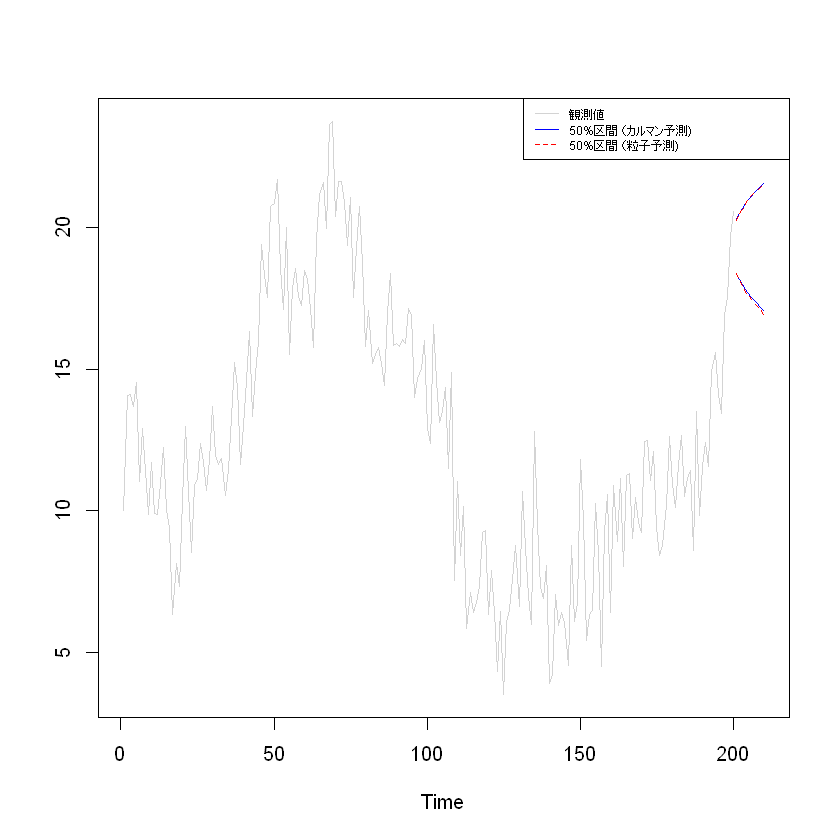

In [7]:
# 結果のプロット
ts.plot(cbind(y, do.call("cbind", a_quant), do.call("cbind", scratch_a_quant)),
        col = c("lightgray", "blue", "blue", "red", "red"),
        lty = c("solid", "solid", "solid", "dashed", "dashed"))

# 凡例
legend(legend = c("観測値", "50%区間 （カルマン予測)",  "50%区間 （粒子予測)"),
       lty = c("solid", "solid", "dashed"),
       col = c("lightgray", "blue", "red"),
       x = "topright", text.width = 70, cex = 0.6)

図11.4を確認すると，両者の結果はほぼ一致する（グラフがほぼ重なっている)．

#### 平滑化

まずは北川アルゴリズムを確認する．

In [8]:
#【パラメータが既知のローカルレベルモデルで粒子平滑化（自作、北川アルゴリズム）】

# 前処理
set.seed(4521)

# 未来の情報を考慮してフィルタリング粒子を再選択する指標を求めるユーザ定義関数
smoothing_index <- function(t_current){
  # 現時点：t_currentにおけるインデックス列
  index <- 1:N

  # t_current+1〜t_maxに対し、仮想的にリサンプリングを繰り返す
  for (t in (t_current+1):t_max){     # 上限を限定すれば固定ラグ平滑化になる
    index <- index[k[, t]]
  }

  # 仮想的にリサンプリングを繰り返して得られた、最終的な再選択指標を返す
  return(index)
}

# 未来の情報を考慮してフィルタリング粒子を再選択
ki <- sapply(1:(t_max-1), function(t){ x[t, smoothing_index(t)] })
ki <- t(cbind(ki, x[t_max, ]))        # 最終時点での平滑化分布を追加

# 平均・25%値・75%値を求める
scratch_s         <- sapply(1:t_max, function(t){
                       mean(ki[t, ])
                     })
scratch_s_quant   <- lapply(c(0.25, 0.75), function(quant){
                       sapply(1:t_max, function(t){
                         quantile(ki[t, ], probs = quant)
                       })
                     })

北川アルゴリズムでは，過去の粒子に対して現時点の規範でのリサンプリングが繰り返される (`smoothing_index()`）．  
フィルタリングの際にリサンプリング用のインデックス列を全時点分保存していたため，ある時点のインデックスに仮想的にリサンプリングを繰り返す処理が後から再現できる．  
この関数の戻り値に基づき，全時点でフィルタリング粒子を再選択し，結果を `ki` に保存する．  
なお，最終時点での平滑化分布はフィルタリング分布に等しいため，関数を用いていない．

#### 図11.5: 自作粒子平滑化（北川アルゴリズム）とカルマン平滑化（パラメータが既知の線形・ガウス型状態空間モデル）

#### (a) 平均

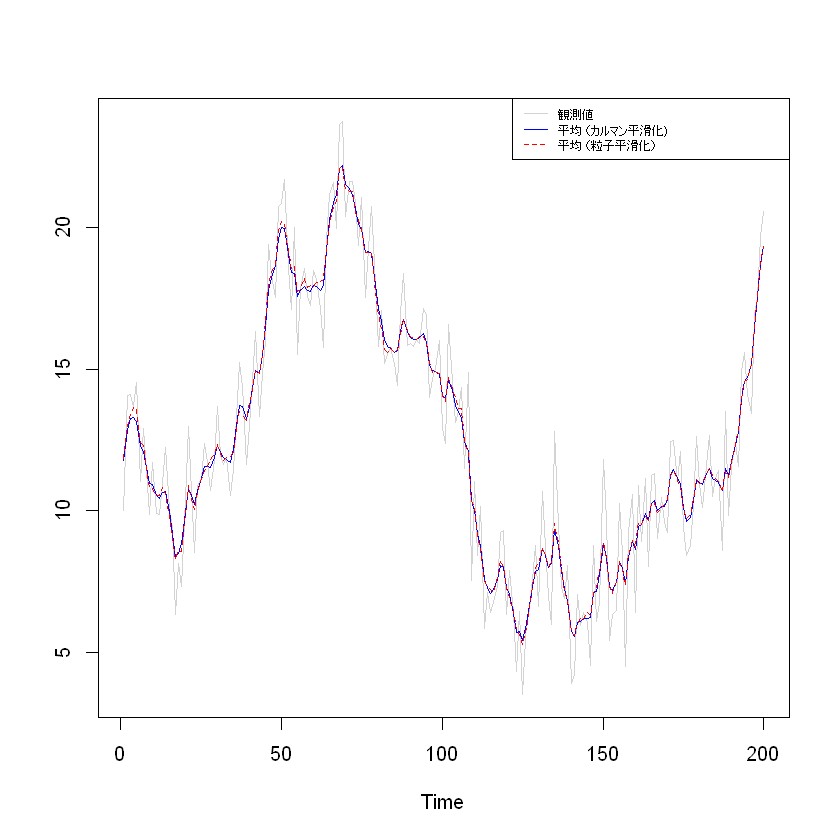

In [9]:
# 結果のプロット
ts.plot(cbind(y, s, scratch_s),
        col = c("lightgray", "blue", "red"),
        lty = c("solid", "solid", "dashed"))

# 凡例
legend(legend = c("観測値", "平均 （カルマン平滑化)",  "平均 （粒子平滑化）"),
       lty = c("solid", "solid", "dashed"),
       col = c("lightgray", "blue", "red"),
       x = "topright", text.width = 70, cex = 0.6)

#### (b) 50%区間

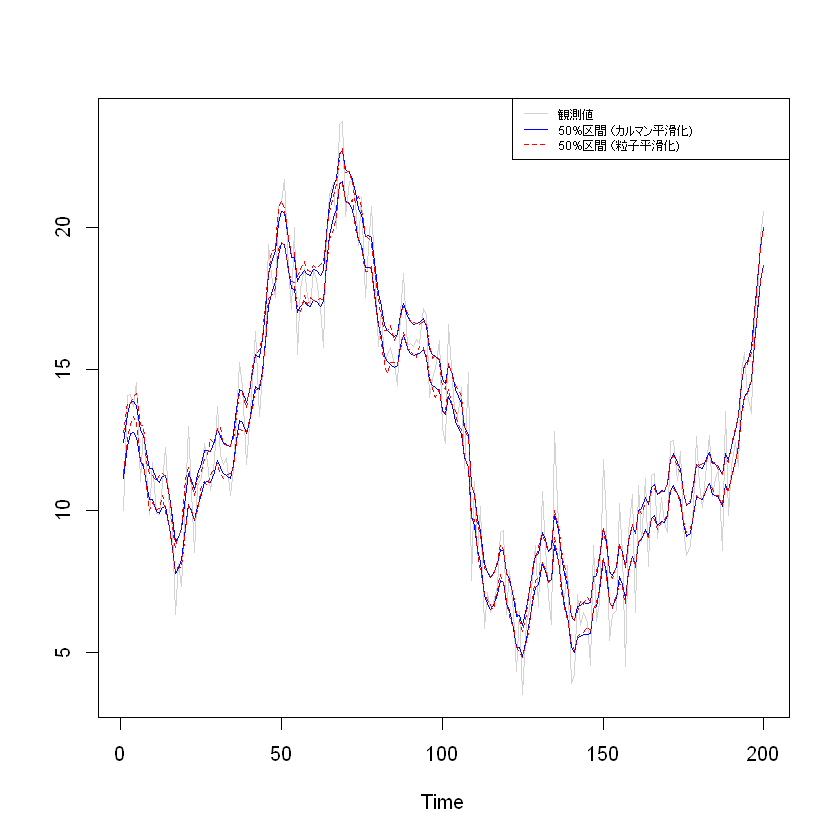

In [10]:
# 結果のプロット
ts.plot(cbind(y, do.call("cbind", s_quant), do.call("cbind", scratch_s_quant)),
        col = c("lightgray", "blue", "blue", "red", "red"),
        lty = c("solid", "solid", "solid", "dashed", "dashed"))

# 凡例
legend(legend = c("観測値", "50%区間 （カルマン平滑化)",  "50%区間 （粒子平滑化)"),
       lty = c("solid", "solid", "dashed"),
       col = c("lightgray", "blue", "red"),
       x = "topright", text.width = 70, cex = 0.6)

図11.5を確認すると，両者の結果はおおむね一致する．  
ただし若干の差はあり，これはフィルタリングに加えて平滑化のための処理が加わったことで，モンテカルロ誤差が増加した影響と考えられる．

FFBSiアルゴリズムも確認する．

In [11]:
# 前処理
set.seed(4521)

# 試行（パス）の最大値
path_max <- 50

# 進捗バーの設定
progress_bar <- txtProgressBar(min = 2, max = path_max, style = 3)

# 平滑化粒子（実現値）
b  <- array(NA_real_, dim = c(t_max, N, path_max))

# 平滑化粒子（重み）
rho  <- matrix(NA_real_, nrow = t_max, ncol = N)
rho[t_max, ]  <- w[t_max, ]

# 試行（パス）分
for (path in 1:path_max){
  # 進捗バーの表示
  setTxtProgressBar(pb = progress_bar, value = path)
  # t_maxにおける平滑化分布の実現値を初期化
  b[t_max, , path] <- sample(x[t_max, ],
                             prob = w[t_max, ], replace = TRUE, size = N)
  # 時間逆方向の処理
  for (t in (t_max-1):1){
    # 重み
    rho[t, ] <- w[t, ] * dnorm(b[t+1, , path], mean = x[t, ], sd = sqrt(mod$W))

    # 重みの規格化
    rho[t, ] <- rho[t, ] / sum(rho[t, ])

    # リサンプリング

    # 未来の情報を考慮してフィルタリング粒子を再選択する指標を求める
    FFBSi_index <- sample(1:N, prob = rho[t, ], replace = TRUE, size = N)

    # 未来の情報を考慮してフィルタリング粒子を再選択
    b[t, , path] <- x[t, FFBSi_index]

    # 重みをリセット
    rho[t, ] <- 1 / N
  }
}

# 平均・25%値・75%値を求める
scratch_s         <- sapply(1:t_max, function(t){
                       mean(b[t, ,])
                     })
scratch_s_quant   <- lapply(c(0.25, 0.75), function(quant){
                       sapply(1:t_max, function(t){
                         quantile(b[t, ,], probs = quant)
                       })
                     })

  |======================================================================| 100%

同時平滑化分布から周辺平滑化分布を求めるために，試行の最大値を500回に設定している．  
また，平滑化分布の粒子に関する実現値と重みについて，必要となる領域を事前に確保している．  
平滑化分布の重みに関しては，時点 `t_max` におけるフィルタリング分布の値で初期化する．  

ここまでが準備段階で，続く2重ループにメインの処理が記載されている．  
最初のループでは試行分の繰り返しを設定し，そのループの直後では時点 `t_max` における平滑化分布の実現値に関して，フィルタリング分布の値をリサンプリングすることで初期化している．  
2つ目のループの中には粒子平滑化（FFBSiアルゴリズム）の処理が，アルゴリズム11.3にそって記載されている．  
- 確率分布表現の状態方程式 (5.10) 式に基づいて，平滑化用の重みを計算する．
- 重みの規格化とリサンプリングを行う．  
このリサンプリングによって，未来の情報を考慮してフィルタリング粒子が再選択される．

このように同時平滑化分布を試行回数分求め，その結果から周辺平滑化分布の要約統計量を求めている．  
平均などの要約統計量を求める場合，ある時点だけで考えても粒子数10,000 × 試行回数500 = 5,000,000 サンプルに対する計算が行われることになるため，それなりに結構時間がかかる．

#### 図11.6: 自作粒子平滑化（FFBSiアルゴリズム）とカルマン平滑化（パラメータが既知の線形・ガウス型状態空間モデル）

#### (a) 平均

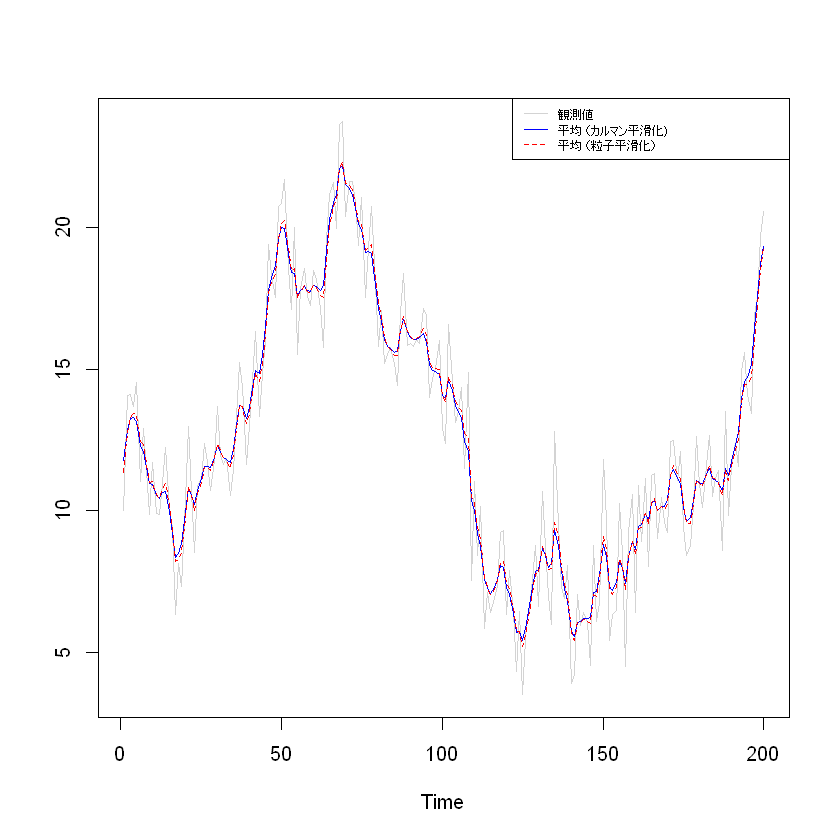

In [12]:
# 結果のプロット
ts.plot(cbind(y, s, scratch_s),
        col = c("lightgray", "blue", "red"),
        lty = c("solid", "solid", "dashed"))

# 凡例
legend(legend = c("観測値", "平均 （カルマン平滑化)",  "平均 （粒子平滑化）"),
       lty = c("solid", "solid", "dashed"),
       col = c("lightgray", "blue", "red"),
       x = "topright", text.width = 70, cex = 0.6)

#### (b) 50%区間

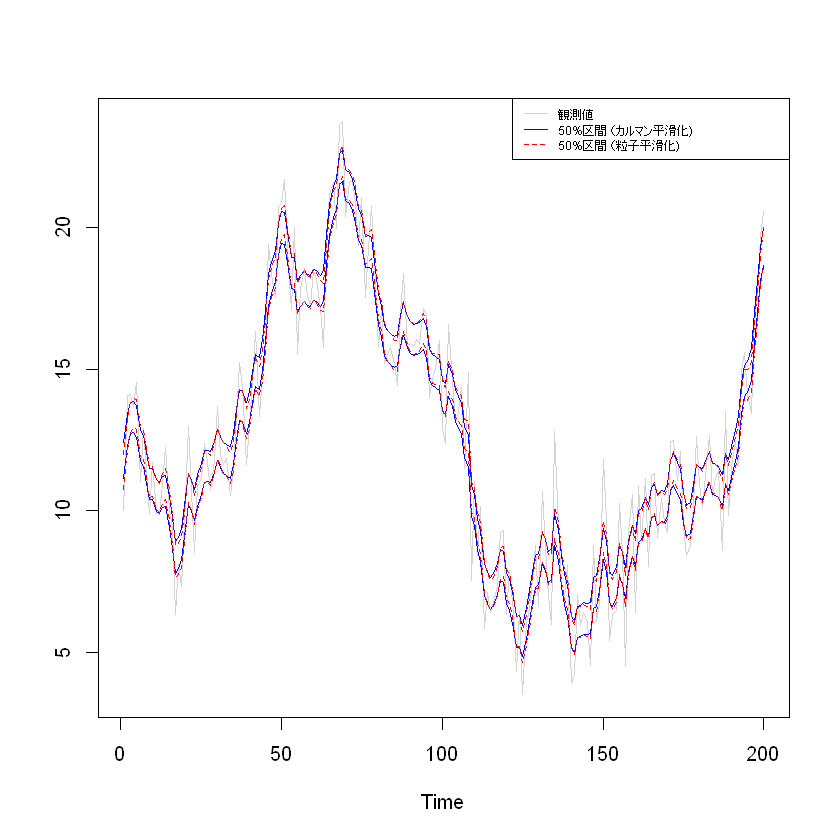

In [13]:
# 結果のプロット
ts.plot(cbind(y, do.call("cbind", s_quant), do.call("cbind", scratch_s_quant)),
        col = c("lightgray", "blue", "blue", "red", "red"),
        lty = c("solid", "solid", "solid", "dashed", "dashed"))

# 凡例
legend(legend = c("観測値", "50%区間 （カルマン平滑化)",  "50%区間 （粒子平滑化)"),
       lty = c("solid", "solid", "dashed"),
       col = c("lightgray", "blue", "red"),
       x = "topright", text.width = 70, cex = 0.6)

図11.6を確認すると，両者の結果はおおむね一致する．  
ただし若干の差はあり，これはフィルタリングに加えて平滑化のための処理が加わったことで，モンテカルロ誤差が増加した影響と考えられる．

最後に，北川アルゴリズムとFFBSiアルゴリズムを比較してみる．  
粒子の退化を確認しやすくするため，粒子数を意図的に500に減少させる．

In [14]:
#【平滑化における粒子退化】

# パラメータが既知のローカルレベルモデルで粒子フィルタリング（自作）

# 前処理
set.seed(4521)

# 粒子フィルタの事前設定
N <- 500                      # 粒子数

# 人工的なローカルレベルモデルに関するデータを読み込み
load(file = "ArtifitialLocalLevelModel.RData")

# ※注意：事前分布を時点1とし、本来の時点1~t_maxを+1シフトして2~t_max+1として扱う

# データの整形(事前分布に相当するダミー分(先頭)を追加)
y <- c(NA_real_, y)

# リサンプリング用のインデックス列は全時点で保存しておく
k <- matrix(1:N, nrow = N, ncol = t_max+1)  

# 事前分布の設定

# 粒子（実現値）
x <- matrix(NA_real_, nrow = t_max+1, ncol = N)
x[1, ] <- rnorm(N, mean = mod$m0, sd = sqrt(mod$C0))

# 粒子（重み）
w <- matrix(NA_real_, nrow = t_max+1, ncol = N)
w[1, ] <- 1 / N

# 時間順方向の処理
for (t in (1:t_max)+1){
  # 状態方程式：粒子（実現値）を生成
  x[t, ] <- rnorm(N, mean = x[t-1, ], sd = sqrt(mod$W))

  # 観測方程式：粒子（重み）を更新
  w[t, ] <- w[t-1, ] * dnorm(y[t], mean = x[t, ], sd = sqrt(mod$V))

  # 重みの規格化
  w[t, ] <- w[t, ] / sum(w[t, ])

  # リサンプリング
  
  # リサンプリング用のインデックス列
  k[, t] <- sample(1:N, prob = w[t, ], replace = TRUE, size = N)

  # 粒子（実現値）：リサンプリング用のインデックス列を新たな通番とする
  x[t, ] <- x[t, k[, t]]

  # 粒子（重み）：リセット
  w[t, ] <- 1 / N
}

# 結果の整形：事前分布の分（先頭）を除去等
y <- ts(y[-1])
k <- k[, -1, drop = FALSE]
x <- x[-1, , drop = FALSE]
w <- w[-1, , drop = FALSE]

#### (a) 北川アルゴリズム

In [15]:
# パラメータが既知のローカルレベルモデルで粒子平滑化（自作，北川アルゴリズム）

# 前処理
set.seed(4521)

# 未来の情報を考慮してフィルタリング粒子を再選択する指標を求めるユーザ定義関数
smoothing_index <- function(t_current){
  # 現時点：t_currentにおけるインデックス列
  index <- 1:N
    
  # t_current+1〜t_maxに対し、仮想的にリサンプリングを繰り返す
  for (t in (t_current+1):t_max){     # 上限を限定すれば固定ラグ平滑化になる
    index <- index[k[, t]]
  }
    
  # 仮想的にリサンプリングを繰り返して得られた、最終的な再選択指標を返す
  return(index)
}

# 未来の情報を考慮してフィルタリング粒子を再選択
ki <- sapply(1:(t_max-1), function(t){ x[t, smoothing_index(t)] })
ki <- t(cbind(ki, x[t_max, ]))        # 最終時点での平滑化分布を追加

# 平均・25%値・75%値を求める
scratch_s         <- sapply(1:t_max, function(t){
                       mean(ki[t, ])
                     })
scratch_s_quant   <- lapply(c(0.25, 0.75), function(quant){
                       sapply(1:t_max, function(t){
                         quantile(ki[t, ], probs = quant)
                       })
                     })

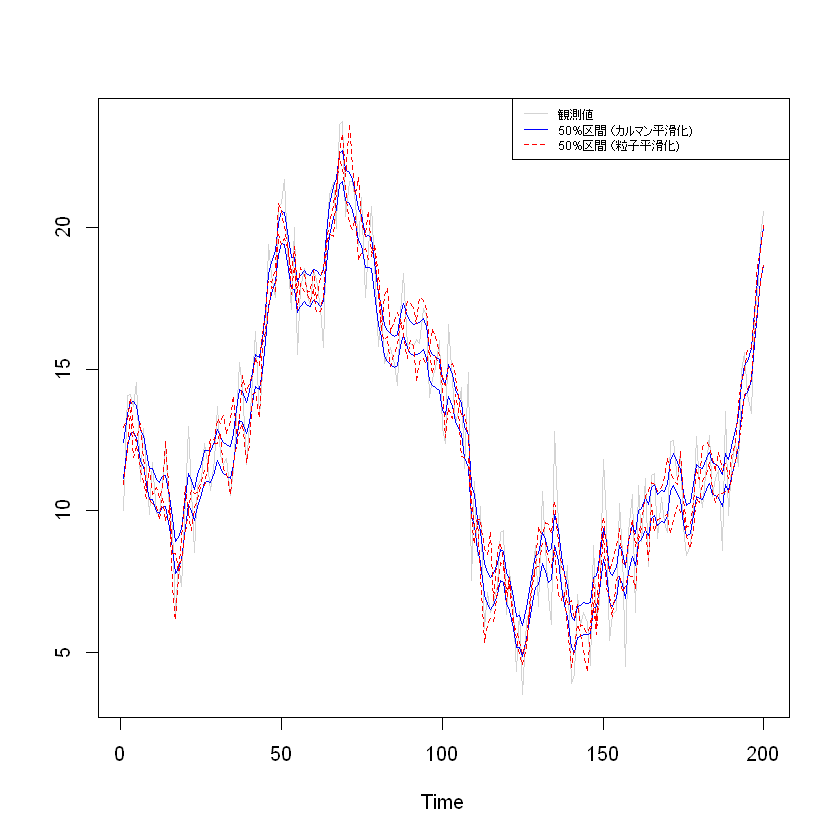

In [16]:
# 結果のプロット
ts.plot(cbind(y, do.call("cbind", s_quant), do.call("cbind", scratch_s_quant)),
        col = c("lightgray", "blue", "blue", "red", "red"),
        lty = c("solid", "solid", "solid", "dashed", "dashed"))

# 凡例
legend(legend = c("観測値", "50%区間 （カルマン平滑化)",  "50%区間 （粒子平滑化)"),
       lty = c("solid", "solid", "dashed"),
       col = c("lightgray", "blue", "red"),
       x = "topright", text.width = 70, cex = 0.6)

#### (b) FFBSiアルゴリズム

In [17]:
# パラメータが既知のローカルレベルモデルで粒子平滑化（自作，FFBSiアルゴリズム）

# 前処理
set.seed(4521)

# 試行（パス）の最大値
path_max <- 500

# 進捗バーの設定
progress_bar <- txtProgressBar(min = 2, max = path_max, style = 3)

# 平滑化粒子（実現値）
b  <- array(NA_real_, dim = c(t_max, N, path_max))

# 平滑化粒子（重み）
rho  <- matrix(NA_real_, nrow = t_max, ncol = N)
rho[t_max, ]  <- w[t_max, ]

# 試行（パス）分
for (path in 1:path_max){
  # 進捗バーの表示
  setTxtProgressBar(pb = progress_bar, value = path)

  # t_maxにおける平滑化分布の実現値を初期化
  b[t_max, , path] <- sample(x[t_max, ], prob = w[t_max, ], replace = TRUE, size = N)

  # 時間逆方向の処理
  for (t in (t_max-1):1){
    # 重み
    rho[t, ] <- w[t, ] * dnorm(b[t+1, , path], mean = x[t, ], sd = sqrt(mod$W))

    # 重みの規格化
    rho[t, ] <- rho[t, ] / sum(rho[t, ])

    # リサンプリング

    # 未来の情報を考慮してフィルタリング粒子を再選択する指標を求める
    FFBSi_index <- sample(1:N, prob = rho[t, ], replace = TRUE, size = N)

    # 未来の情報を考慮してフィルタリング粒子を再選択
    b[t, , path] <- x[t, FFBSi_index]

    # 重みをリセット
    rho[t, ] <- 1 / N
  }
}

# 平均・25%値・75%値を求める
scratch_s         <- sapply(1:t_max, function(t){
                       mean(b[t, ,])
                     })
scratch_s_quant   <- lapply(c(0.25, 0.75), function(quant){
                       sapply(1:t_max, function(t){
                         quantile(b[t, ,], probs = quant)
                       })
                     })

  |======================================================================| 100%

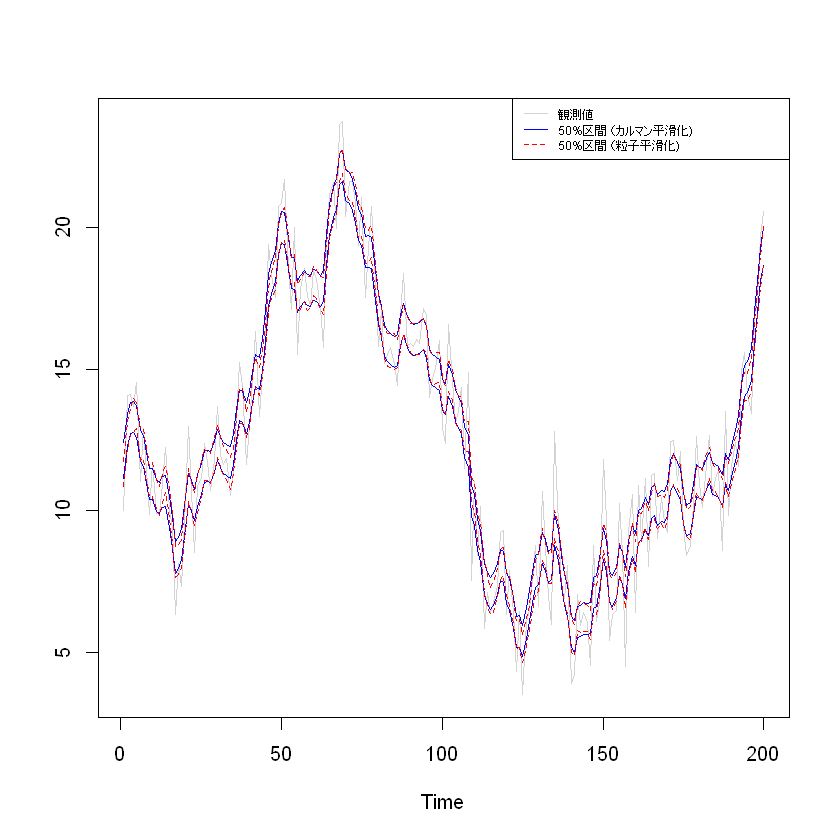

In [18]:
# 結果のプロット
ts.plot(cbind(y, do.call("cbind", s_quant), do.call("cbind", scratch_s_quant)),
        col = c("lightgray", "blue", "blue", "red", "red"),
        lty = c("solid", "solid", "solid", "dashed", "dashed"))

# 凡例
legend(legend = c("観測値", "50%区間 （カルマン平滑化)",  "50%区間 （粒子平滑化)"),
       lty = c("solid", "solid", "dashed"),
       col = c("lightgray", "blue", "red"),
       x = "topright", text.width = 70, cex = 0.6)

北川アルゴリズムでは粒子の退化の影響が分かりやすく，時間を遡るほどカルマン平滑化の結果との乖離が激しくなり，時点80付近より前では25%値と75%値が同じ値になっている．  
FFBSiアルゴリズムでは粒子の退化がより抑制され，カルマン平滑化の結果との乖離が少なくなっている．  
なお．粒子数が十分多くラグ長が長過ぎなければ北川アルゴリズムでも問題になることはない．  
北川アルゴリズムには状態方程式に関するパラメータが未知の場合にも適用が容易であるという利点もあるため，どちらのアルゴリズムを使うかは問題に応じて使い分けるのがよい．